<a href="https://colab.research.google.com/github/gspiga/TweetSentimentAnalysis/blob/main/Let'sCook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

EDA

In [2]:
my_data=pd.read_csv("Tweets.csv")


FileNotFoundError: ignored

RNN

In [ ]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)   # Remove URLs
    text = re.sub(r'<.*?>', '', text)     # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)   # Remove punctuation and special chars
    text = text.lower()                   # Convert to lowercase
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

my_data['cleaned_text'] = my_data['text'].apply(clean_text)


In [ ]:
clean_text("My @Southwest flight was delayed AGAIN!! Airline rep was entirely unhelpful :()")

'southwest flight delayed airline rep entirely unhelpful'

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(my_data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(my_data['cleaned_text'])

# Define maximum sequence length
max_seq_length = max([len(x) for x in sequences])
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

data = pad_sequences(sequences, maxlen=max_seq_length)


Found 15402 unique tokens.


In [ ]:
le = LabelEncoder()
my_data['sentiment'] = le.fit_transform(my_data['airline_sentiment'])


In [ ]:
labels = my_data['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class TweetDataset(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        return tweet, label

# Assuming X_train, y_train are your input and output training data
train_dataset = TweetDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False)





In [ ]:
import torch
import torch.nn as nn

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                   bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
      #print("Input text shape:", text.size())  # Debug, working now
      embedded = self.dropout(self.embedding(text))
      #print("After embedding:", embedded.size())  # Debug, working now
      output, (hidden, cell) = self.rnn(embedded)
      #print("Output shape:", output.size(), "Hidden shape:", hidden.size())  # Debug, working nw!

      hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
      hidden = self.dropout(hidden)

      # Ensure the hidden state is correctly reshaped for the fully connected layer
      hidden = hidden.view(hidden.shape[0], -1)  # Reshape without squeezing
      return self.fc(hidden)



# Example parameters
tokenizer = Tokenizer()
tokenizer.fit_on_texts(my_data['cleaned_text'])
word_index = tokenizer.word_index

# Add 1 because the index 0 is reserved and not assigned to any word
vocab_size = len(word_index) + 1
embedding_dim = 100
hidden_dim = 256
output_dim = 3 # for 3 sentiment classes
n_layers = 2
bidirectional = True
dropout = 0.5

model = SentimentModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)


In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for tweets, labels in train_loader:
        optimizer.zero_grad()
        #print("Input shape:", tweets.size())  # Debugging print
        predictions = model(tweets)
        #print("Output shape:", predictions.size(), "Labels shape:", labels.size())  # Debugging print
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}: Loss = {loss.item()}')


Epoch 1: Loss = 0.6884427070617676
Epoch 2: Loss = 0.5450142621994019
Epoch 3: Loss = 0.8621058464050293
Epoch 4: Loss = 0.46893492341041565
Epoch 5: Loss = 0.5513229966163635


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    total_correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total
    return accuracy


In [ ]:
accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 77.36%


BERT

In [ ]:
#!pip install transformers

In [ ]:
import torch
from transformers import TFBertForSequenceClassification,AutoTokenizer,BertTokenizer,AdamW,get_linear_schedule_with_warmup,AutoModel,BertModel

In [ ]:
my_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_text,sentiment
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),virginamerica dhepburn said,1
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),virginamerica plus youve added commercials exp...,2
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),virginamerica didnt today must mean need take ...,1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),virginamerica really aggressive blast obnoxiou...,0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),virginamerica really big bad thing,0


In [ ]:
train_data, val_data = train_test_split(my_data, test_size=0.2, random_state=42)
#using BERT Encoder with padding and lemmatization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encoding=tokenizer(list(train_data['text']),truncation=True,padding=True)
valid_encoding=tokenizer(list(val_data['text']),truncation=True,padding=True)

sentiment_dict = {'positive': 0, 'negative': 1, 'neutral': 2}

train_labels = train_data['airline_sentiment'].map(sentiment_dict).values.astype('int64')
valid_labels = val_data['airline_sentiment'].map(sentiment_dict).values.astype('int64')

In [ ]:
print(len(train_labels))
print(len(valid_labels))
print(len(train_encoding))
print(len(valid_encoding))

11712
2928
3
3


In [ ]:
import tensorflow as tf

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encoding), train_labels)).shuffle(len(train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(valid_encoding), valid_labels)).batch(32)

# Load the pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Fine-tune the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
366/366 [==============================] - 234s 491ms/step - loss: 0.5266 - accuracy: 0.7897 - val_loss: 0.4043 - val_accuracy: 0.8436
Epoch 2/10
366/366 [==============================] - 177s 484ms/step - loss: 0.3108 - accuracy: 0.8860 - val_loss: 0.3913 - val_accuracy: 0.8497
Epoch 3/10
366/366 [==============================] - 178s 486ms/step - loss: 0.1923 - accuracy: 0.9319 - val_loss: 0.4400 - val_accuracy: 0.8480
Epoch 4/10
366/366 [==============================] - 178s 486ms/step - loss: 0.1146 - accuracy: 0.9647 - val_loss: 0.5418 - val_accuracy: 0.8467
Epoch 5/10
366/366 [==============================] - 186s 508ms/step - loss: 0.0689 - accuracy: 0.9798 - val_loss: 0.6081 - val_accuracy: 0.8415
Epoch 6/10
366/366 [==============================] - 178s 486ms/step - loss: 0.0516 - accuracy: 0.9851 - val_loss: 0.6772 - val_accuracy: 0.8429
Epoch 7/10
366/366 [==============================] - 178s 485ms/step - loss: 0.0407 - accuracy: 0.9883 - val_loss: 0.7446 -

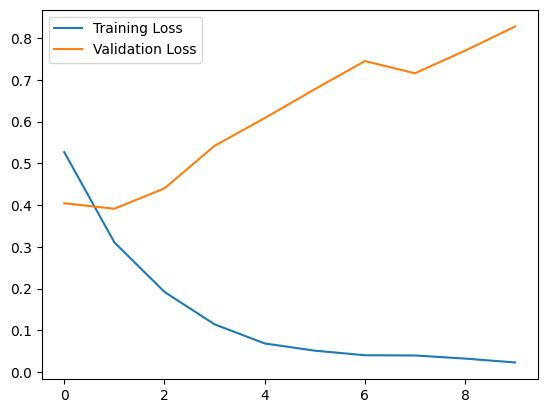

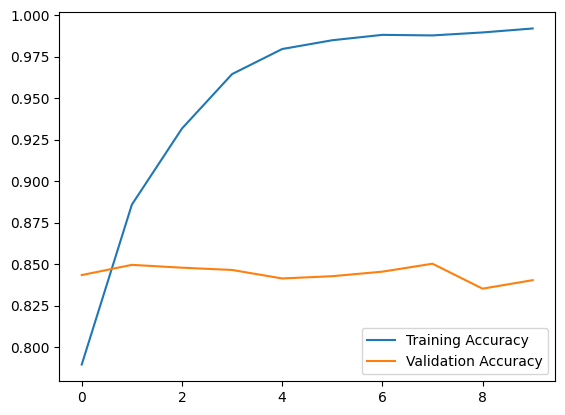

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()